# Section 5: Regridding

## Set up

In [1]:
from pathlib import Path
import numpy as np

from esmf_regrid.experimental.unstructured_scheme import MeshToGridESMFRegridder, GridToMeshESMFRegridder
import iris
from iris import load, load_cube
from iris.coords import DimCoord
from iris.cube import Cube
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

## Example: Regridding LFRic data

Suppose we need to compare data located on two different kinds of grids. One is located on a UM style "latlon" _grid_ and one is located on an LFRic style cubed sphere UGRID _mesh_. Data can be translated from the grid to the mesh and vice versa via _regridding_. We will demonstrate with the following files:

In [2]:
from testdata_fetching import lfric_orography, um_orography
mesh_cube = lfric_orography()
mesh_cube

Surface Altitude (m),--
Shape,221184
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,Topology data of 2D unstructured mesh
location,face
Scalar coordinates,
forecast_period,21600 seconds
forecast_reference_time,2021-03-24 00:00:00


In [3]:
grid_cube = um_orography()
grid_cube

<iris 'Cube' of surface_altitude / (m) (latitude: 480; longitude: 640)>

Regridding unstructured data is more complex than the regridders contained in Iris and requires making use of powerful libraries (`ESMF`). The `iris-esmf-regrid` package provides a bridge from iris to esmf with objects that interact directly with iris cubes. The `MeshToGridESMFRegridder` class allows the regridding of (LFRic style) mesh cubes onto (UM style) latlon grid cubes.

First we initialise the regridder object with a source mesh cube and target grid cube...

In [6]:
# Initialise the regridder.
# This object can be re-used and also saved/re-loaded.
# Note: it may take a few seconds to initialise the regridder.
regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube)

...Then we use that regridder object to translate the data onto the grid of the target cube.

In [7]:
# Regrid the mesh cube.
result = regridder(mesh_cube)
print(result)

surface_altitude / (m)              (latitude: 480; longitude: 640)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        forecast_period             21600 seconds
        forecast_reference_time     2021-03-24 00:00:00
        time                        2021-03-24 06:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        title                       'Created by xios'


The reason this is done in two steps is because initialising a regridder is potentially quite expensive if the grids or meshes involved are large. Once initialised, a regridder can regrid many source cubes (defined on the same source grid/mesh) onto the same target. We can demonstrate this by regridding a different cube using the same regridder.

In [8]:
# Load an air temperature cube.
from testdata_fetching import lfric_temp
mesh_temp = lfric_temp()

# We can check that this cube shares the same mesh.
assert mesh_temp.mesh == mesh_cube.mesh

mesh_temp

Air Temperature (K),time,pressure,--
Shape,24,17,221184
Dimension coordinates,,,
time,x,-,-
pressure,-,x,-
Mesh coordinates,,,
latitude,-,-,x
longitude,-,-,x
Auxiliary coordinates,,,
forecast_period,x,-,-
Mesh,,,


In [9]:
# Regrid the new mesh cube using the same regridder.
# Note how the time coordinate is also transposed in the result.
result_2 = regridder(mesh_temp)
result_2

<iris 'Cube' of air_temperature / (K) (time: 24; pressure: 17; latitude: 480; longitude: 640)>

We can save time in future runs by saving and loading a regridder with `save_regridder` and `load_regridder`.

*Note:* The information for the regridder is saved as a NetCDF file so the file name must have a `.nc` extension.

In [10]:
# This code is commented for the time being to avoid generating files.

# from esmf_regrid.experimental.io import load_regridder, save_regridder

# save_regridder(regridder, "lf_to_um_regridder.nc")
# loaded_regridder = load_regridder("lf_to_um_regridder.nc")

We can compare the regridded file to an equivalent file from the UM.

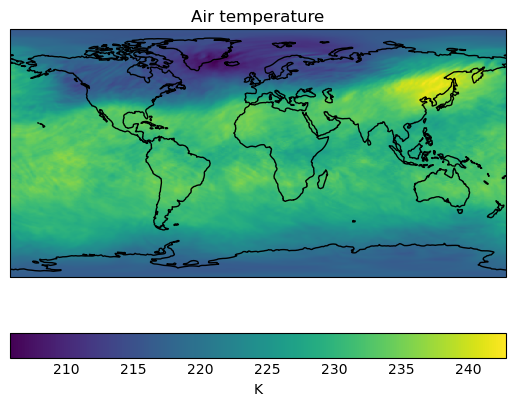

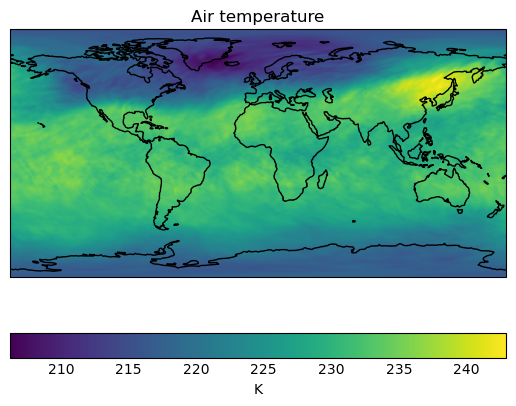

In [11]:
import iris.quickplot as iqplt
import matplotlib.pyplot as plt

from testdata_fetching import um_temp
grid_temp = um_temp()

iqplt.pcolormesh(grid_temp[0, 0])
plt.gca().coastlines()
plt.show()

iqplt.pcolormesh(result_2[0, 0])
plt.gca().coastlines()
plt.show()

We can then plot the difference between the UM data and the data regridded from LFRic. Since our data is now on a latlon grid we can do this with matplotlib as normal.

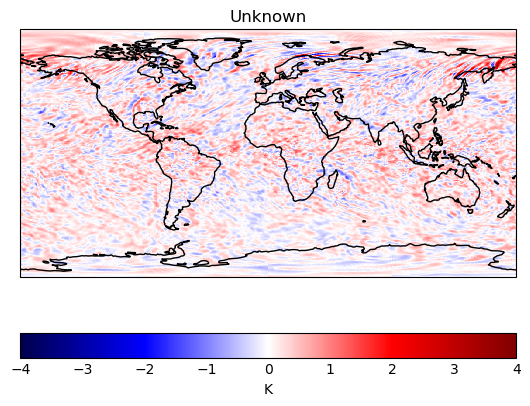

In [12]:
temp_diff = result_2 - grid_temp

iqplt.pcolormesh(temp_diff[0, 0], vmin=-4,vmax=4, cmap="seismic")
plt.gca().coastlines()
plt.show()

In [13]:
# Consider a bonus task to measure the relative time taken.
# import time... etc

We can also regrid from latlon grids to LFRic style meshes using `GridToMeshESMFRegridder`.

In [14]:
# Initialise the regridder.
g2m_regridder = GridToMeshESMFRegridder(grid_cube, mesh_cube)
# Regrid the grid cube.
result_3 = g2m_regridder(grid_cube)
result_3

Surface Altitude (m),--
Shape,221184
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,Topology data of 2D unstructured mesh
location,face
Scalar coordinates,
forecast_period,21600 seconds
forecast_reference_time,2021-03-24 00:00:00


## Exercise 1: Comparing regridding methods

By default, regridding uses the area weighted `conservative` method. We can also use the bilinear regridding method.

**Step 1:** Use the `method="bilinear"` keyword to initialise a bilinear `MeshToGridESMFRegridder` with arguments `mesh_cube` and `grid_cube`.

In [15]:
bilinear_regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube, method="bilinear")

**Step 2:** Use this regridder to regrid `mesh_cube`.

In [16]:
bilinear_result = bilinear_regridder(mesh_cube)

**Step 3:** Compare this result with the result from the default area weighted conservative regridder.

In [17]:
bilinear_diff = bilinear_result - result

**Step 4:** Plot the results and the difference using `iris.quickplot` and `matplotlib`.

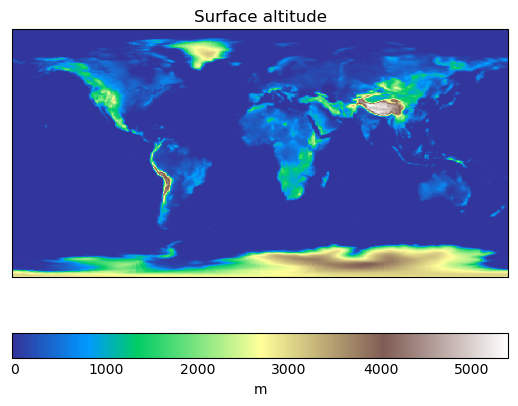

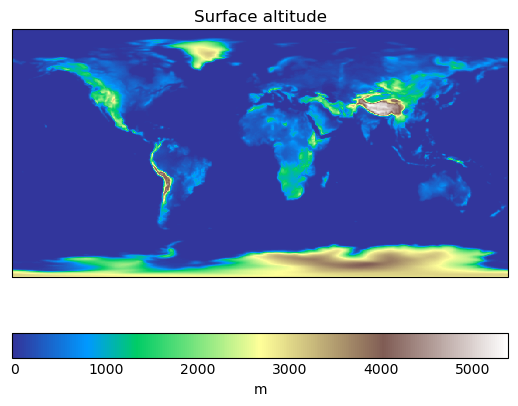

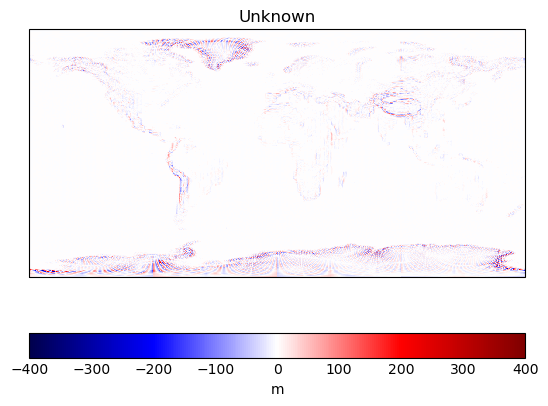

In [18]:
import iris.quickplot as iqplt
import matplotlib.pyplot as plt

iqplt.pcolormesh(result, cmap="terrain")
plt.show()
iqplt.pcolormesh(bilinear_result, cmap="terrain")
plt.show()
iqplt.pcolormesh(bilinear_diff, vmin=-400,vmax=400, cmap="seismic")
plt.show()

In [19]:
# Bonus Exercises:
# - calculate the difference between methods for the GridToMeshESMFRegridder.
# - calculate the difference between raw data and data which has been round tripped.
# (e.g. regrid from mesh to grid then from grid to mesh)
# - demonstrate that the data in the grid file was probably a result of regridding from the mesh file.

## Exercise 2: Zonal means

A zonal mean is the area weighted average over a defined region. e.g. a band of latitude/longitude.
Calculating zonal means can be done as a regridding operation where the zone is defined by the target cube.
In this example, the target cube will contain a single cell.

**Step 1:** Define a latitude coordinate whose bounds are `[[-20, 20]]`. Remember to set the standard name to be `"latitude"` and the units to be `"degrees"`

In [20]:
lat_band = DimCoord(0, bounds=[[-20, 20]], standard_name="latitude", units="degrees")


**Step 2:** Define a longitude coordinate whose bounds are `[[-180, 180]]`. Remember to set the standard name to be `"longitude"` and the units to be `"degrees"`

In [21]:
lon_full = DimCoord(0, bounds=[[-180, 180]], standard_name="longitude", units="degrees")

**Step 3:** Create a single celled cube (i.e. `Cube([[0]])`) and attach the latitude and longitude coordinates to it.

In [22]:
lat_band_cube = Cube([[0]])
lat_band_cube.add_dim_coord(lat_band, 0)
lat_band_cube.add_dim_coord(lon_full, 1)
print(lat_band_cube)

unknown / (unknown)                 (latitude: 1; longitude: 1)
    Dimension coordinates:
        latitude                             x             -
        longitude                            -             x


**Step 4:** Create a regridder from `mesh_cube` to the single celled cube you created.

*Note:* ESMF represents all lines as sections of great circles rather than lines of constant latitude. This means that `MeshToGridESMFRegridder` would  fail to properly handle such a large cell. We can solve this problem by using the `resolution` keyword. By providing a `resolution`, we divide each cell into as many sub-cells each bounded by the same latitude bounds.

If we initialise a regridder with `MeshToGridESMFRegridder(src_mesh, tgt_grid, resolution=10)`, then the lines of latitude bounding each of the cells in `tgt_grid` will be *approximated* by 10 great circle sections.

Initialise a `MeshToGridESMFRegridder` with `mesh_cube` and your single celled cube as its arguments and with a `resolution=10` keyword.

In [23]:
lat_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=10)

**Step 5:** Apply this regridder to `mesh_cube` and print the data from this result (i.e. `print(result_cube.data)`).

In [24]:
lat_band_mean_10 = lat_band_mean_calculator_10(mesh_cube)
print(lat_band_mean_10.data)

[[132.29930129838036]]


**Step 6:** Repeat step 4 and 5 for `resolution=100`.

Note the difference in value. Also note that it takes more time to initialise a regridder with higher resolution.

In [25]:
lat_band_mean_calculator_100 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=100)
lat_band_mean_100 = lat_band_mean_calculator_100(mesh_cube)
print(lat_band_mean_100.data)

[[131.4283200362707]]


**Step 7:** Repeat steps 1 - 6 for latitude bounds `[[-90, 90]]`, longitude bounds `[[-40, 40]]` and resolutions 2 and 10.

*Note:* Unlike lines of constant latitude, lines of constant longitude are already great circle arcs.This might suggest that the `resolution` argument is unnnecessary, however these arcs are 180 degrees which ESMF is unable to represent so we still need a `resolution` of at least 2. In this case, an increase in resolution will not affect the accuracy since a resolution of 2 will already have maximum accuracy. Note how the results are the equal.

In [26]:
lat_full = DimCoord(0, bounds=[[-90, 90]], standard_name="latitude", units="degrees")
lon_band = DimCoord(0, bounds=[[-40, 40]], standard_name="longitude", units="degrees")

lon_band_cube = Cube([[0]])
lon_band_cube.add_dim_coord(lat_full, 0)
lon_band_cube.add_dim_coord(lon_band, 1)

lon_band_mean_calculator_2 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=2)
lon_band_mean_2 = lon_band_mean_calculator_2(mesh_cube)
print(lon_band_mean_2.data)

lon_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=10)
lon_band_mean_10 = lon_band_mean_calculator_10(mesh_cube)
print(lon_band_mean_10.data)

[[257.1388582231515]]
[[257.1388582231515]]


In [27]:
# Bonus Exercise:
# Create a regridder onto a single celled cube which represents the whole earth.
# Use this regridder to compare how well bilinear regridding and area weighted
# regridding preserve area weighted mean after round tripping.